In [ ]:
import pandas as pd
df = pd.read_csv('C:/Users/HOME/Documents/yeast/consumer_complaints - Copy.csv',dtype={5:'unicode',11:'unicode'})
df.head()

,date_received,Product,sub_product,issue,sub_issue,Consumer complaint narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [ ]:
from io import StringIO
col = ['Product', 'Consumer complaint narrative']
df = df[col]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.columns = ['Product', 'Consumer_complaint_narrative']
df['category_id'] = df['Product'].factorize()[0]
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
df.head()

,Product,Consumer_complaint_narrative,category_id
125423,Debt collection,On XXXX/XXXX/16 I receiveda letter from Wilber...,0
125435,Debt collection,I paid my co-pay and XXXX XXXX paid their part...,0
125450,Credit reporting,"Dear Sir, With full responsibility i would lik...",1
125451,Consumer Loan,Me and my wife percussed a car back in XXXX 20...,2
125452,Credit reporting,"Experian is reporting foreclosure "" started on...",1


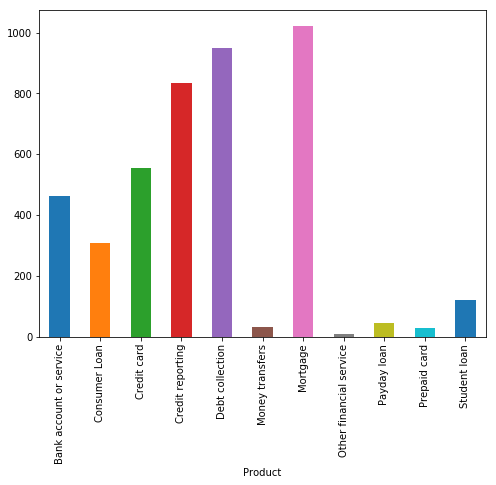

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.category_id
features.shape

(4359, 12397)

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
. deposit
. overdraft
  . Most correlated bigrams:
. checking account
. overdraft fees
# 'Consumer Loan':
  . Most correlated unigrams:
. car
. vehicle
  . Most correlated bigrams:
. santander consumer
. auto loan
# 'Credit card':
  . Most correlated unigrams:
. citi
. card
  . Most correlated bigrams:
. american express
. credit card
# 'Credit reporting':
  . Most correlated unigrams:
. transunion
. experian
  . Most correlated bigrams:
. trans union
. credit report
# 'Debt collection':
  . Most correlated unigrams:
. collection
. debt
  . Most correlated bigrams:
. collection agency
. collect debt
# 'Money transfers':
  . Most correlated unigrams:
. gram
. western
  . Most correlated bigrams:
. money gram
. western union
# 'Mortgage':
  . Most correlated unigrams:
. modification
. mortgage
  . Most correlated bigrams:
. mortgage company
. loan modification
# 'Other financial service':
  . Most correlated unigrams:
. workers
.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [ ]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting']


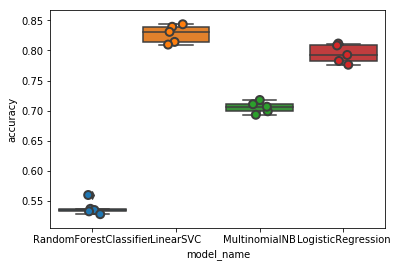

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.827472
LogisticRegression        0.794184
MultinomialNB             0.705424
RandomForestClassifier    0.538628
Name: accuracy, dtype: float64

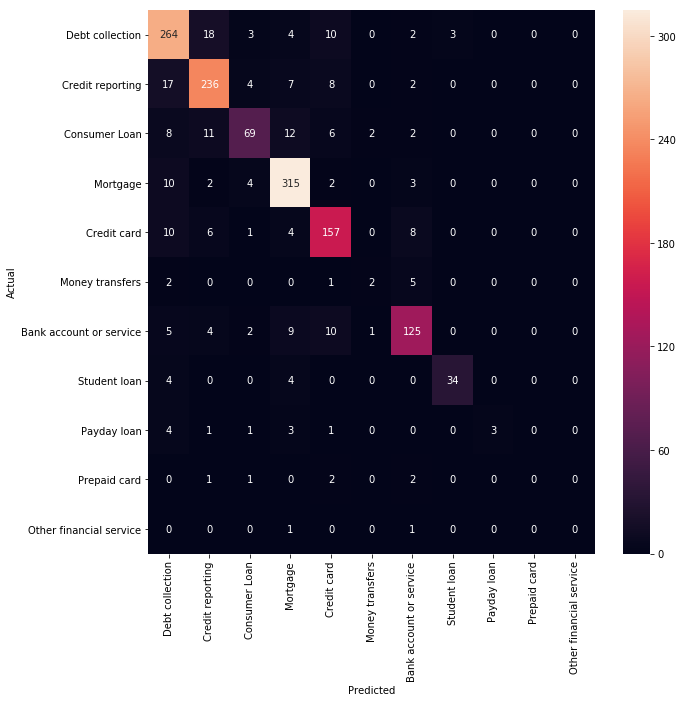

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
      print('')

'Credit reporting' predicted as 'Debt collection' : 17 examples.


,Product,Consumer_complaint_narrative
144830,Credit reporting,I have been disputing and demanding validation...
126392,Credit reporting,There is an account listed that is not mine re...
140832,Credit reporting,ASKED QUESTIONS THAT I WAS NOT AWARE OF \n
143688,Credit reporting,i have several medical bills from XXXX iowa th...
134145,Credit reporting,"XXXX XXXX XXXX XXXX, through its representativ..."
142113,Credit reporting,I have been unable to gain access to my experi...
143247,Credit reporting,"Unknown, and no verification provided, I am al..."
138510,Credit reporting,I have credit monitoring services through my b...
126990,Credit reporting,The XXXX XXXX organization sent my account to ...
129139,Credit reporting,I have XXXX of debt reporting on my credit for...



'Mortgage' predicted as 'Debt collection' : 10 examples.


,Product,Consumer_complaint_narrative
141954,Mortgage,Tried to log on to seterus.com to make a payme...
129732,Mortgage,I 'm filing a complaint against Real Time Reso...
137851,Mortgage,We keep getting phone calls from someone who s...
133226,Mortgage,I had originally filed a complaint in XXXX of ...
140067,Mortgage,"wells fargo bill me for atty services XXXX, XX..."
135487,Mortgage,CHASE HOME FINANCE LLC XXXX - I HAVE NEVER PAI...
126005,Mortgage,Harassing phone calls multiple times per day f...
133502,Mortgage,As of today 's date XX/XX/XXXX I have not rece...
127171,Mortgage,Went through a company called Mortgage Lenders...
127401,Mortgage,XXXX case number I got a phone call from chase...



'Credit card' predicted as 'Debt collection' : 10 examples.


,Product,Consumer_complaint_narrative
138104,Credit card,I paid a company called XXXX XXXX a total of X...
141621,Credit card,On this day at approximately XXXX I received a...
137484,Credit card,Chase shows up on my credit report as that I '...
130474,Credit card,I received an unsolicited 'NetSpend Prepaid XX...
140565,Credit card,XXXX XXXX XXXX -I believe that the above debt ...
139657,Credit card,Capital One is reporting in accurate and have ...
135568,Credit card,I was checking out what was involved in starti...
143993,Credit card,I filed a Chapter XXXX Bankruptcy and it was d...
140797,Credit card,There is a judgment against me from Citi Bank....
138429,Credit card,I am in debt to Bank of America with a past cr...



'Debt collection' predicted as 'Credit reporting' : 18 examples.


,Product,Consumer_complaint_narrative
128713,Debt collection,My current credit report has a collection item...
142085,Debt collection,A company named Procollect contacted me about ...
134773,Debt collection,In response to my prior complaint IQ stated th...
143901,Debt collection,I have contacted USCB America 3 times by certi...
135215,Debt collection,Financial credit network is reporting false in...
127575,Debt collection,Universal Acceptance is inaccurately reporting...
137846,Debt collection,this account is pulling my credit score by bei...
143357,Debt collection,"Cach , LLC is reporting an account on my credi..."
126417,Debt collection,XXXX is reporting a paid collection that was s...
127029,Debt collection,I was a student at XXXX XXXX XXXX from XX/XX/X...



'Consumer Loan' predicted as 'Credit reporting' : 11 examples.


,Product,Consumer_complaint_narrative
125708,Consumer Loan,Honda advertises no money down lease on new Ci...
128048,Consumer Loan,XXXX credit report deleted my car loan complet...
132885,Consumer Loan,"My car is financed with Chase, I bought the ca..."
142493,Consumer Loan,I have reviewed my credit report and I have fo...
139271,Consumer Loan,I performed the initial steps to see loan refi...
143605,Consumer Loan,"Background : I filed Chapter XXXX BK in XXXX, ..."
137240,Consumer Loan,I purchased a XXXX Chevrolet Silverado from XX...
128836,Consumer Loan,"On XXXX XXXX, 2015 I made a call to my lien ho..."
143331,Consumer Loan,I received my annual credit report from XXXX. ...
135995,Consumer Loan,I have been trying to get this information del...



'Consumer Loan' predicted as 'Mortgage' : 12 examples.


,Product,Consumer_complaint_narrative
130696,Consumer Loan,Case number-XXXX.Thank you for taking the time...
128068,Consumer Loan,"I have always made my loan payments on time, e..."
141226,Consumer Loan,I intended to buy a home with a mortgage in 20...
131097,Consumer Loan,I took out XXXX separate loans through Citizen...
130665,Consumer Loan,When I applied for this refinancing loan I was...
144539,Consumer Loan,Best Egg approved my personal loan for {$32000...
133283,Consumer Loan,"On XXXX XXXX 2015, we applied for an auto loan..."
142893,Consumer Loan,The purpose of this complaint is based on a re...
129643,Consumer Loan,We purchased this property in 2002. Recently w...
136731,Consumer Loan,CFPB made a deal with Toyota to give back mone...



'Debt collection' predicted as 'Credit card' : 10 examples.


,Product,Consumer_complaint_narrative
141734,Debt collection,A time share scam took place and I was taken f...
131972,Debt collection,In XXXX XXXX I signed a payment agreement on a...
127144,Debt collection,I lost my job about two months ago and my Macy...
142972,Debt collection,I had a XXXX XXXX credit card. I had unexpecte...
126528,Debt collection,"I have a Platinum Citi card, and I missed paym..."
129731,Debt collection,applied for credit card from total rewards cre...
130358,Debt collection,I have been having hardship since my job of se...
125516,Debt collection,The XXXX is using deceptive practices in an at...
127139,Debt collection,well my concerns is about my credit I have pro...
140820,Debt collection,"XXXX XXXX XXXX ( XXXX XXXX XXXX XXXX XXXX, XXX..."



'Bank account or service' predicted as 'Credit card' : 10 examples.


,Product,Consumer_complaint_narrative
138472,Bank account or service,"My corp chain # XXXX, XXXX XXXX, XXXX XXXX XXX..."
136082,Bank account or service,"Recently, I filed a Reg E claim with my instit..."
126004,Bank account or service,I purchased an item via my paycard XXXX XXXX. ...
128190,Bank account or service,I signed up for a program with Synchrony Bank....
136668,Bank account or service,I am running into filing a dispute with Wells ...
142996,Bank account or service,Citizens Bank XXXX Headquarters : XXXX Citizen...
144745,Bank account or service,From XXXX XXXX XXXX XXXX : American Express Bu...
136045,Bank account or service,Bank of America allowed XXXX withdraws from a ...
140099,Bank account or service,I bought something off ebay and was required t...
133954,Bank account or service,XXXX my wife and I have Macy 's accounts and h...


In [ ]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bank account or service':
  . Top unigrams:
       . bank
       . overdraft
  . Top bigrams:
       . debit card
       . overdraft fees
# 'Consumer Loan':
  . Top unigrams:
       . vehicle
       . car
  . Top bigrams:
       . auto loan
       . consumer usa
# 'Credit card':
  . Top unigrams:
       . card
       . capital
  . Top bigrams:
       . credit card
       . american express
# 'Credit reporting':
  . Top unigrams:
       . experian
       . transunion
  . Top bigrams:
       . xxxx account
       . trans union
# 'Debt collection':
  . Top unigrams:
       . debt
       . owe
  . Top bigrams:
       . trying collect
       . showing credit
# 'Money transfers':
  . Top unigrams:
       . western
       . gram
  . Top bigrams:
       . western union
       . money gram
# 'Mortgage':
  . Top unigrams:
       . mortgage
       . modification
  . Top bigrams:
       . mortgage company
       . complaint xxxx
# 'Other financial service':
  . Top unigrams:
       . questionin

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred,target_names=df['Product'].unique()))

                         precision    recall  f1-score   support

        Debt collection       0.81      0.87      0.84       304
       Credit reporting       0.85      0.86      0.85       274
          Consumer Loan       0.81      0.63      0.71       110
               Mortgage       0.88      0.94      0.91       336
            Credit card       0.80      0.84      0.82       186
        Money transfers       0.40      0.20      0.27        10
Bank account or service       0.83      0.80      0.82       156
           Student loan       0.92      0.81      0.86        42
            Payday loan       1.00      0.23      0.38        13
           Prepaid card       0.00      0.00      0.00         6
Other financial service       0.00      0.00      0.00         2

            avg / total       0.83      0.84      0.83      1439



C:\Users\HOME\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
